# 1) Set Up

In [ ]:
  #Liste des modules à importer pour le set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Import fichier - Step 
#Instructions : télecharger fichier en local puis choisir le fichier après exécution de cette cellule)
#documentation ici si besoin -> https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92). Fichier ici si besoin -> https://www.kaggle.com/prachi13/customer-analytics

from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [ ]:
#Import fichier - Step 2

import io
df1 = pd.read_csv(io.BytesIO(uploaded['Train.csv']))

#Le data set est maintenant dans un Dataframe Pandas

In [ ]:
#Test pour vérifier que le fichier est correctement uploadé

df1.head(5)



,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
#Test pour vérifier que le fichier est correctement uploadé

df1.tail()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
10998,10999,D,Ship,2,5,155,5,low,F,6,1639,0


In [ ]:
#Enlever la colonne ID (inutile pour la suite)
df = df1.drop("ID", axis=1)

In [ ]:
df.isna().sum()

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

# 2) Visualisations

In [ ]:
# Analyse descriptive des variables numériques
#création d'un dataframe num_data
num_data = df.select_dtypes(include = ['int64', 'float64'])
#moyenne, médiane, quantiles, min, max
stats = pd.DataFrame(num_data.mean(),columns = ['moyenne'])
stats['median'] = num_data.median()
stats['mean_med_diff'] = abs(stats['moyenne'] - stats['median'])
stats[['q1', 'q2', 'q3']] = num_data.quantile(q = [0.25,0.5,0.75]).transpose()
stats['min'] = num_data.min()
stats['max'] = num_data.max()
stats['min_max_diff'] = stats['max'] - stats['min']
stats['ecart_type'] = num_data.std()
stats.round(2)


,moyenne,median,mean_med_diff,q1,q2,q3,min,max,min_max_diff,ecart_type
Customer_care_calls,4.05,4.0,0.05,3.0,4.0,5.0,2,7,5,1.14
Customer_rating,2.99,3.0,0.01,2.0,3.0,4.0,1,5,4,1.41
Cost_of_the_Product,210.20,214.0,3.80,169.0,214.0,251.0,96,310,214,48.06
Prior_purchases,3.57,3.0,0.57,3.0,3.0,4.0,2,10,8,1.52
Discount_offered,13.37,7.0,6.37,4.0,7.0,10.0,1,65,64,16.21
Weight_in_gms,3634.02,4149.0,514.98,1839.5,4149.0,5050.0,1001,7846,6845,1635.38
Reached.on.Time_Y.N,0.60,1.0,0.40,0.0,1.0,1.0,0,1,1,0.49


In [ ]:
#Analyse des variables catégorielles
cat_data = df.select_dtypes(include = "object")
main_category = cat_data.value_counts() 
main_category

Warehouse_block  Mode_of_Shipment  Product_importance  Gender
F                Ship              low                 M         619
                                                       F         580
                                   medium              F         575
                                                       M         508
A                Ship              low                 F         321
                                                                ... 
                 Road              high                F          12
B                Road              high                M          12
F                Flight            high                F          11
D                Flight            high                F          10
                 Road              high                F           7
Length: 90, dtype: int64

In [ ]:
cat_data.mode()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,F,Ship,low,F


In [ ]:
#Hypothèse 1 : les commandes arrivent  temps parce que notre entreprise accordent des réductions aux clients
#test statistique entre 'Discount_offered' et 'Reached.on.Time_Y.N'
from scipy.stats import pearsonr
pd.DataFrame(pearsonr( df['Discount_offered'],df['Reached.on.Time_Y.N']), index = ['pearson_coeff','p-value'], columns = ['resultat_test'])
#comme la p-value < 5%, les deux variables sont dépendantes; cependant la corrélation est  modérément positive : r de Pearson = 0,397

,resultat_test
pearson_coeff,0.397108
p-value,0.000000


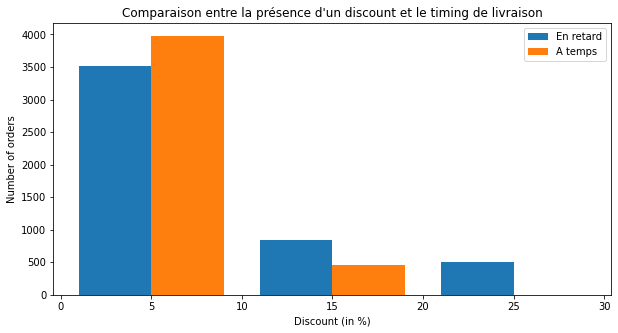

In [ ]:
#Visualisation 2 : Comparaison entre le Discount et le timing de livraison 
#Rappel : Il y a une corrélation modérée entre "Reached on Time" et "Discount Offered" (0.40)

df_ontime = df[df["Reached.on.Time_Y.N"] == 1]
df_late = df[df["Reached.on.Time_Y.N"] == 0]
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
plt.figure(figsize=[10,5])
plt.hist(x = [df_ontime["Discount_offered"], df_late["Discount_offered"]], bins= [0,10,20,30], label = ["En retard", "A temps"])
plt.xlabel("Discount (in %)")
plt.ylabel("Number of orders")
plt.title("Comparaison entre la présence d'un discount et le timing de livraison")
plt.legend();

#Les produits dont la remise est inférieure à 10 ont une plus grande probabilité d'arriver en retard


In [ ]:
#Hypothèse 2 : les remises accordées ont une incidence sur le poids des chaque colis expédié
#test statistique entre 'Discount_offered' et 'Reached.on.Time_Y.N'
from scipy.stats import pearsonr
pd.DataFrame(pearsonr( df['Weight_in_gms'],df['Discount_offered']), index = ['pearson_coeff','p-value'], columns = ['resultat_test'])
#comme la p-value < 5%, les deux variables sont dépendantes; cependant la corrélation est  modérément négative : r de Pearson = -0,376

,resultat_test
pearson_coeff,-0.376067
p-value,0.000000


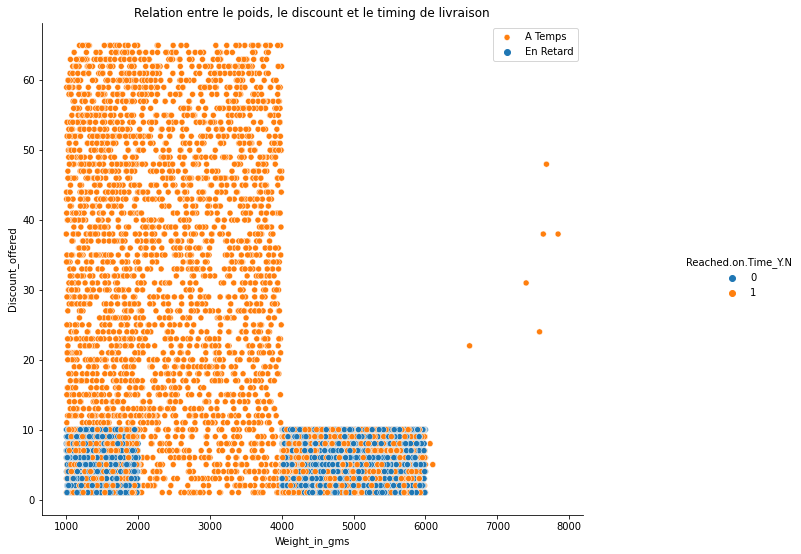

In [ ]:
#Visualisation 3 : Relation entre le poids des produits et le discount (corrélation négative de 0.38)

g = sns.relplot(x="Weight_in_gms", y="Discount_offered", hue='Reached.on.Time_Y.N', data=df)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
plt.legend(loc='upper right', labels=['A Temps', 'En Retard'])
plt.title("Relation entre le poids, le discount et le timing de livraison");

# Les produits lourds ont une remise faible, cela explique la corrélation négative
# Sur les produits avec un discount, ceux pesants entre 4 et 6 kilos ou moins de 2 kilos & dont la remise est comprise entre 0 et 10% sont ceux arrivant en retard.

In [ ]:
#Hypothèse 3 : la relation entre le volume des colis et timing de livraison par entrepôt
#test statistique entre 'Weight_in_gms' et 'Reached.on.Time_Y.N'
from scipy.stats import pearsonr
pd.DataFrame(pearsonr( df['Weight_in_gms'],df['Reached.on.Time_Y.N']), index = ['pearson_coeff','p-value'], columns = ['resultat_test'])
#comme la p-value < 5%, les deux variables sont dépendantes; cependant la corrélation est négative : r de Pearson = -0,002

,resultat_test
pearson_coeff,-2.687926e-01
p-value,2.354658e-181


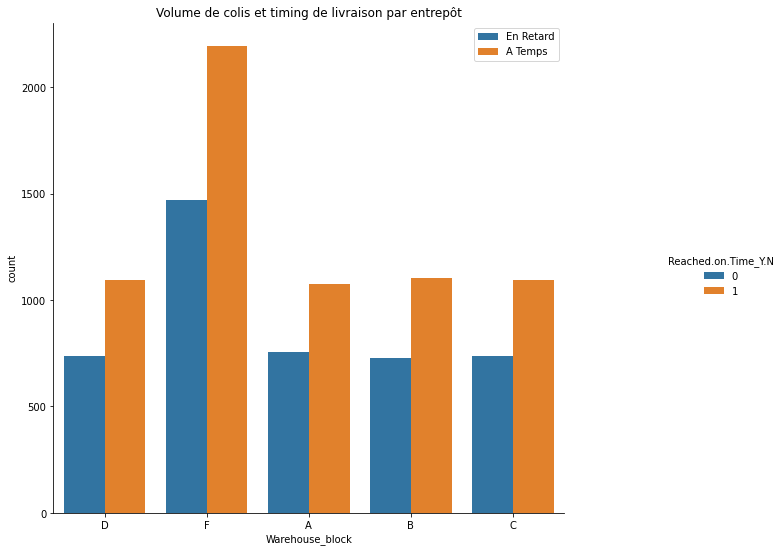

In [ ]:
#Visualisation 4 : Volume de colis et mode d'expédition par entrepôt

order = df[df["Reached.on.Time_Y.N"] == 1].value_counts().index
g = sns.catplot(x="Warehouse_block", kind="count", hue='Reached.on.Time_Y.N', data=df);
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
plt.legend(loc='upper right', labels=['En Retard', 'A Temps'])
plt.title('Volume de colis et timing de livraison par entrepôt');

#L'entrepôt F a un impact important sur le variable cible car il stock un grand nombre de colis

In [ ]:
# analyse Warehouse_block et Reached on Time 

df_bis = df.rename(columns={'Reached.on.Time_Y.N': 'Reached'})
import statsmodels.api 

result = statsmodels.formula.api.ols('Reached ~ Warehouse_block', data=df_bis).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Warehouse_block,4.0,0.262162,0.065540,0.27225,0.896006
Residual,10994.0,2646.657376,0.240737,NaN,NaN


In [ ]:
#Hypothese 4 :le coût des produits a une influence sur le nombre d'appels clients
#test statistique entre 'Customer_care_calls' et ''
from scipy.stats import pearsonr
pd.DataFrame(pearsonr( df['Customer_care_calls'],df['Cost_of_the_Product']), index = ['pearson_coeff','p-value'], columns = ['resultat_test'])
#comme la p-value < 5%, les deux variables sont dépendantes; la corrélation est proche de 0

,resultat_test
pearson_coeff,3.231818e-01
p-value,8.847667e-266


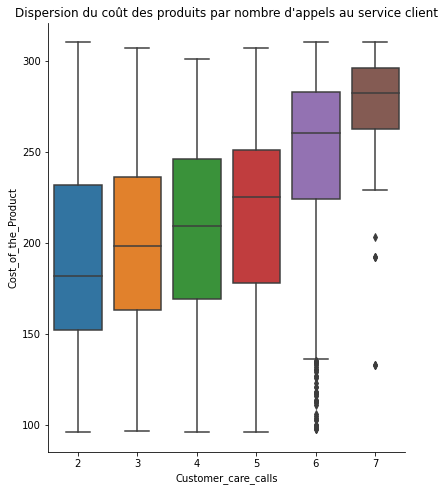

In [ ]:
#Visualisation 5 : Dispersion du coût des produits par nombre de customer calls
#Il y a une corrélation faible (0.32)entre les "Customer Care Calls" et le "Cost of The Product"
g = sns.catplot(x = "Customer_care_calls", y = "Cost_of_the_Product",kind = "box", data = df)
g.fig.set_figwidth(6)
g.fig.set_figheight(7)
plt.title("Dispersion du coût des produits par nombre d'appels au service client");

#Hypothèse : plus le produit est cher, plus le client va demander des informations sur le suivi des expéditions.

In [ ]:
#Hypothèse 5:  l'impact du genre sur la note client, le nombre d'appel et le nombre d'achats
#test statistique entre 'Gender' et 'Customer_rating'
import statsmodels.api 
result = statsmodels.formula.api.ols('Customer_rating~Gender', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
#comme la p-value >5%, les deux variables sont indépendantes

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,0.169211,0.169211,0.084671,0.771069
Residual,10997.0,21976.847427,1.998440,NaN,NaN


In [ ]:
#test statistique entre 'Gender' et 'Customer_care_calls'
import statsmodels.api 
result = statsmodels.formula.api.ols('Customer_care_calls~Gender', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
#comme la p-value >5%, les deux variables sont indépendantes

,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,0.092849,0.092849,0.071252,0.789528
Residual,10997.0,14330.285913,1.303109,NaN,NaN


In [ ]:
#test statistique entre 'Gender' et 'prior_purchase'
import statsmodels.api 
result = statsmodels.formula.api.ols('Prior_purchases~Gender', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
#comme la p-value >5%, les deux variables sont indépendantes

,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,2.251141,2.251141,0.970692,0.324529
Residual,10997.0,25503.240449,2.319109,NaN,NaN


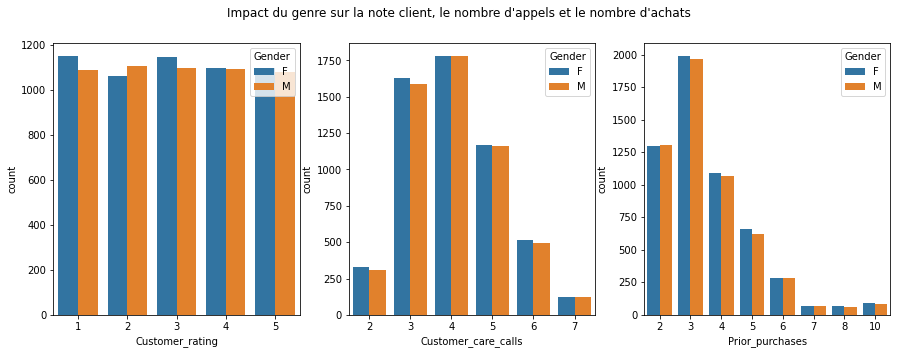

In [ ]:
#Visualisation 6 : Impact du genre sur la note client, le nombre d'appel et le nombre d'achats

j = 1
var = ['Customer_rating','Customer_care_calls','Prior_purchases']
plt.figure(figsize = (15,5))
for i in var:
    plt.subplot(1,3,j)
    sns.countplot(x = i , data = df, hue= 'Gender')
    j +=1
plt.suptitle("Impact du genre sur la note client, le nombre d'appels et le nombre d'achats");

# Nous observons que les chiffres pour les deux sexes sont à peu près égaux.

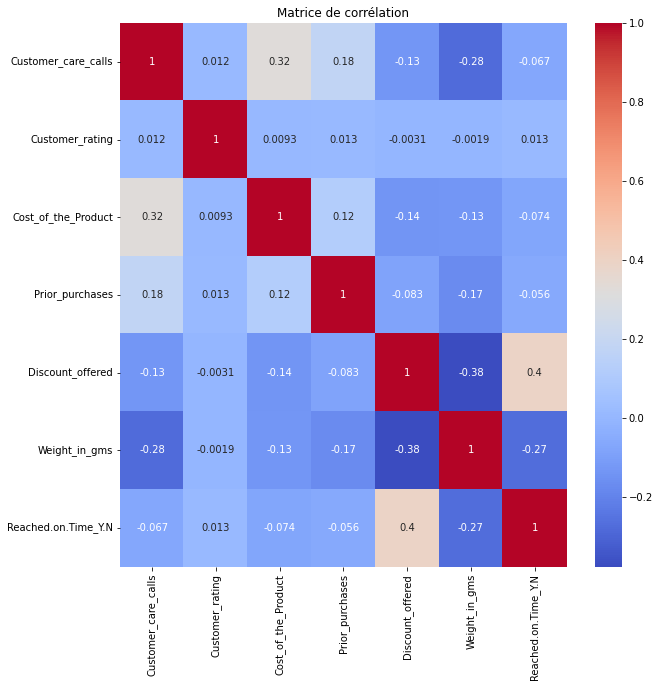

In [ ]:
#Synthèse des corrélationsentre les différentes variables 
#Visualisation 1 : Corrélation entre les variables

cor=df.corr()
fig,ax = plt.subplots(figsize=(10,10))
fig = sns.heatmap(cor, annot=True, ax=ax, cmap = "coolwarm");
plt.title("Matrice de corrélation");

# Comme on peut le voir sur le graphique ci-dessous, les trois groupes suivants sont en corrélation :
#1) "Reached on Time" VS "Discount Offered" corrélation modéré (0.40)
#2) "Customer Care Calls" VS  "Cost of The Product" corrélation faible (0.32)
#3) "Weight of The Product in Grams" VS "Discount Offered" corrélation faible négative(-0.38)

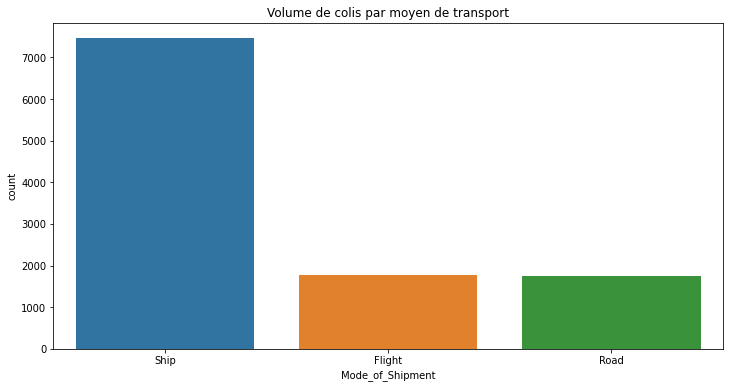

In [ ]:
#Autre visualisation : analyse du volume de colis par moyen de transport
plt.figure(figsize=[12,6])
ship_order=df['Mode_of_Shipment'].value_counts().index
sns.countplot(data=df,x='Mode_of_Shipment',order=ship_order)
plt.title('Volume de colis par moyen de transport');

In [ ]:
#Suite à la visualisation des différentes variables retenues explicatives en fonction de la variable à expliquer nous pouvons supprimer les valeurs supérieures à 1.5 fois la hauteur de la boîte à moustache.
df = df[df['Weight_in_gms'] > 2500]
df = df[df['Prior_purchases']< 6.5]
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
7,F,Flight,4,1,233,2,low,F,48,2804,1
10,C,Flight,3,4,189,2,medium,M,12,2888,1
11,F,Flight,4,5,232,3,medium,F,32,3253,1


#3) Preprocessing


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6936 entries, 1 to 10962
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      6936 non-null   object
 1   Mode_of_Shipment     6936 non-null   object
 2   Customer_care_calls  6936 non-null   int64 
 3   Customer_rating      6936 non-null   int64 
 4   Cost_of_the_Product  6936 non-null   int64 
 5   Prior_purchases      6936 non-null   int64 
 6   Product_importance   6936 non-null   object
 7   Gender               6936 non-null   object
 8   Discount_offered     6936 non-null   int64 
 9   Weight_in_gms        6936 non-null   int64 
 10  Reached.on.Time_Y.N  6936 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 650.2+ KB


In [ ]:
#On vérifie qu'il n'y a pas de valeurs manquantes

df.isna().sum()

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [ ]:
#On affiche le nom des colonnes

df.columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

In [ ]:
#On sépare en varaibles catégorielles et numériques. On met la variable target de côté pour faciliter l'exécution de la cellule suivante.

categorical = ['Warehouse_block','Mode_of_Shipment','Customer_rating', 'Product_importance', 'Gender']
numeric = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
target = ['Reached.on.Time_Y.N']

In [ ]:
#On encode les valeurs catégorielles
Dummy_encoded_feats = pd.get_dummies(df, columns= categorical)

#On encode notre valeur target. On l'encode à part pour avoir 1 seule colonne (avec 1 si le colis est arrivé à temps et 0 si il est en retard).
Dummy_encoded_target = pd.get_dummies(df["Reached.on.Time_Y.N"], drop_first = True)

#On drop la colonne target du dataframe feats
Dummy_encoded_feats = Dummy_encoded_feats.drop(columns=['Reached.on.Time_Y.N'])

#On vérifie que le code s'est bien exécuté
Dummy_encoded_target.value_counts()
Dummy_encoded_target.head(5)
Dummy_encoded_feats.head(5)


,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Customer_rating_1,Customer_rating_2,Customer_rating_3,Customer_rating_4,Customer_rating_5,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
1,4,216,2,59,3088,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1
2,2,183,4,48,3374,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
7,4,233,2,48,2804,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0
10,3,189,2,12,2888,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
11,4,232,3,32,3253,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0


In [ ]:
#On fusionne les 2 dataframes dummy encoded
df_dummy_encoded = pd.concat([Dummy_encoded_feats, Dummy_encoded_target], axis = 1)

#On renomme la colonne target avec un nom plus clair
df_dummy_encoded.rename({1: 'On_Time?'}, axis=1, inplace=True)

In [ ]:
#On vérifie que le code s'ext bien exécuté
df_dummy_encoded.head(5)
#C'est le cas, notre dataframe df_dummy_encoded est prêt pour le processing !


,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Customer_rating_1,Customer_rating_2,Customer_rating_3,Customer_rating_4,Customer_rating_5,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,On_Time?
1,4,216,2,59,3088,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1
2,2,183,4,48,3374,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1
7,4,233,2,48,2804,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1
10,3,189,2,12,2888,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1
11,4,232,3,32,3253,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1


In [ ]:
df_dummy_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6936 entries, 1 to 10962
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Customer_care_calls        6936 non-null   int64
 1   Cost_of_the_Product        6936 non-null   int64
 2   Prior_purchases            6936 non-null   int64
 3   Discount_offered           6936 non-null   int64
 4   Weight_in_gms              6936 non-null   int64
 5   Warehouse_block_A          6936 non-null   uint8
 6   Warehouse_block_B          6936 non-null   uint8
 7   Warehouse_block_C          6936 non-null   uint8
 8   Warehouse_block_D          6936 non-null   uint8
 9   Warehouse_block_F          6936 non-null   uint8
 10  Mode_of_Shipment_Flight    6936 non-null   uint8
 11  Mode_of_Shipment_Road      6936 non-null   uint8
 12  Mode_of_Shipment_Ship      6936 non-null   uint8
 13  Customer_rating_1          6936 non-null   uint8
 14  Customer_rating_2      

# 4) Processing - Standard - Evaluation des modèles



In [ ]:
#Import des modules nécessaires

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix 
from sklearn import preprocessing

In [ ]:
target = df_dummy_encoded['On_Time?']
data = df_dummy_encoded.iloc[:,0:-1]
#On sépare target / data

scaler = preprocessing.StandardScaler()
df = data.select_dtypes(include="int64") 
#On recupère les 5 premières colonnes pour appliquer un StandardScaler afin de normaliser 
#Opération réalisée sur les 5 premières colonnes uniquement car les autres colonnes contiennent uniquement des 0 ou des 1
dfnum = pd.DataFrame(scaler.fit_transform(df),index=df.index, columns = df.columns) 
#On applique Standardscaler
dfnum.head(5)

dfcat = data.select_dtypes(include="uint8") 
#On recupère le reste des colonnes

data = dfnum.join(dfcat) 
#On join le deux dataframes
data.head(5)

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Customer_rating_1,Customer_rating_2,Customer_rating_3,Customer_rating_4,Customer_rating_5,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
1,0.195023,0.207948,-1.073609,3.575806,-1.819716,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1
2,-1.902158,-0.557815,0.887042,2.764031,-1.491365,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
7,0.195023,0.602432,-1.073609,2.764031,-2.145771,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0
10,-0.853567,-0.418586,-1.073609,0.107313,-2.049332,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
11,0.195023,0.579227,-0.093284,1.583267,-1.630283,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66)
#On sépare en groupe train/test

In [ ]:
Models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}
#On crée un dictionnaire avec tous les modèles

In [ ]:
for name, model in Models.items():
    model.fit(X_train, y_train)
    print(name, ":", model.score(X_test, y_test))
#On affiche le score de chaque modèle
#Gradient Boosting semble être le modèle le plus performant

Random Forest : 0.6152737752161384
Gradient Boosting : 0.6563400576368876
Logistic Regression : 0.6231988472622478
KNN : 0.6131123919308358
Decision Tree : 0.6066282420749279


#5) Processing - Avancé - Decision Tree Models

Decision Tree model (criterion = 'entropy')

In [ ]:
dt_clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
pd.crosstab(y_test, y_pred_dt, rownames = ['Classes réelles'], colnames = ['Classes prédites'])


Classes prédites,0,1
Classes réelles,,
0,651,8
1,470,259


In [ ]:
impVar={"Variable":data.columns,"Importance":dt_clf.feature_importances_}
print(pd.DataFrame(impVar).sort_values(by="Importance",ascending=False).head(8))


                     Variable  Importance
4               Weight_in_gms    0.989930
9           Warehouse_block_F    0.005494
5           Warehouse_block_A    0.004577
0         Customer_care_calls    0.000000
13          Customer_rating_1    0.000000
21                   Gender_F    0.000000
20  Product_importance_medium    0.000000
19     Product_importance_low    0.000000


[Text(167.4, 195.696, 'X[2] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(141.64615384615385, 152.208, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(193.15384615384616, 152.208, 'X[3] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(103.01538461538462, 108.72, 'X[2] <= 4.95\nentropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(51.50769230769231, 65.232, 'X[3] <= 1.65\nentropy = 0.146\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(25.753846153846155, 21.744, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(77.26153846153846, 21.744, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(154.52307692307693, 65.232, 'X[3] <= 1.55\nentropy = 0.918\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(128.76923076923077, 21.744, 'entropy = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(180.27692307692308, 21.744, 'entropy = 0.918\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(283.2923076923077, 108.72, 'X[2] <= 4.85\nentropy = 0.151\nsamples = 

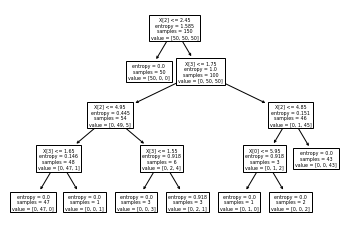

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = dt_clf.fit(iris.data, iris.target)
tree.plot_tree(clf)


Decision Tree model (criterion = 'gini')

In [ ]:
dt_clf_gini = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=321)
dt_clf_gini.fit(X_train,y_train)
y_pred = dt_clf_gini.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames = ['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,651,8
1,470,259


In [ ]:
impVar_gini={"Variable":data.columns,"Importance":dt_clf_gini.feature_importances_}
print(pd.DataFrame(impVar_gini).sort_values(by="Importance",ascending=False).head(8))

                     Variable  Importance
4               Weight_in_gms    0.984658
9           Warehouse_block_F    0.007411
18    Product_importance_high    0.004611
5           Warehouse_block_A    0.003319
0         Customer_care_calls    0.000000
13          Customer_rating_1    0.000000
21                   Gender_F    0.000000
20  Product_importance_medium    0.000000


[Text(167.4, 195.696, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(141.64615384615385, 152.208, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(193.15384615384616, 152.208, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(103.01538461538462, 108.72, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(51.50769230769231, 65.232, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(25.753846153846155, 21.744, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(77.26153846153846, 21.744, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(154.52307692307693, 65.232, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(128.76923076923077, 21.744, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(180.27692307692308, 21.744, 'gini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(283.2923076923077, 108.72, 'X[2] <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]'),
 Text(25

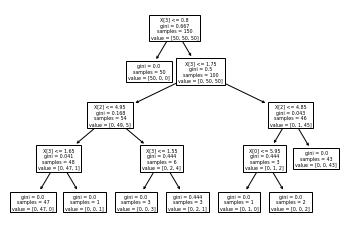

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = dt_clf_gini.fit(iris.data, iris.target)
tree.plot_tree(clf)


#6) Processing - Avancé - Pipelines

In [ ]:
#On importe les modules nécessaires

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

In [ ]:
#On isole la variable target
df = df1
target = df['Reached.on.Time_Y.N']
data = df.drop('Reached.on.Time_Y.N', axis=1)

In [ ]:
#On sépare en variables ordinales, nominales, numériques

ordinal = [
    'Gender',
    'Product_importance'
]

nominal = [
    'Warehouse_block',
    'Mode_of_Shipment'
]
#Rappel : "nominal" data can only be classified, "ordinal" data can be classified and ordered, "numerical" data is a number that can be measured

numerical = [
    'Cost_of_the_Product',
    'Discount_offered',
    'Weight_in_gms',
    'Prior_purchases',
    'Customer_care_calls',
    'Customer_rating'
]

#On crée les pipelines, on utilise 3 encoders différents pour chaque type de données

transformer_for_ordinal = Pipeline([
    ('ordinal', OrdinalEncoder())
])

transformer_for_nominal = Pipeline([
    ('nominal', OneHotEncoder())
])

transformer_for_numerical = Pipeline([
    ('numerical', MinMaxScaler())
])

#On crée le Transformer

Transformer = ColumnTransformer(transformers=[
    ('ordinal', transformer_for_ordinal, ordinal),
    ('nominal', transformer_for_nominal, nominal),
    ('numerical', transformer_for_numerical, numerical)
])


In [ ]:
#On applique les transformations sur les data.

data_transform = pd.DataFrame(Transformer.fit_transform(data))
data_transform

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.378505,0.671875,0.033893,0.125,0.4,0.25
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.560748,0.906250,0.304894,0.000,0.4,1.00
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.406542,0.734375,0.346676,0.250,0.0,0.25
3,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.373832,0.140625,0.025712,0.250,0.2,0.50
4,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.411215,0.703125,0.216654,0.125,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.728972,0.000000,0.078451,0.375,0.4,0.00
10995,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.635514,0.078125,0.035939,0.375,0.4,0.00
10996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.682243,0.046875,0.022498,0.375,0.6,0.75
10997,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.593458,0.015625,0.030533,0.500,0.6,0.25


In [ ]:
#On sépare en groupe train/test
X_train, X_test, y_train, y_test = train_test_split(data_transform, target, test_size=0.2, random_state=66)

In [ ]:
Models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}
#On crée un dictionnaire avec tous les modèles

In [ ]:
for name, model in Models.items():
    model.fit(X_train, y_train)
    print(name, ":", model.score(X_test, y_test))
#On affiche le score de chaque modèle
#Gradient Boosting semble toujours être le modèle le plus performant (score 0,67), cependant le score du modèle est meilleur avec ce processing (score 0,66 avec le processing classique).

Random Forest : 0.6668181818181819
Gradient Boosting : 0.6695454545454546
Logistic Regression : 0.6413636363636364
KNN : 0.6172727272727273
Decision Tree : 0.6395454545454545


# 7) Interprétabilité du modèle Gradient Boosting

Code à lancer avant lancement du Processing - Avancé - Pipelines

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier()

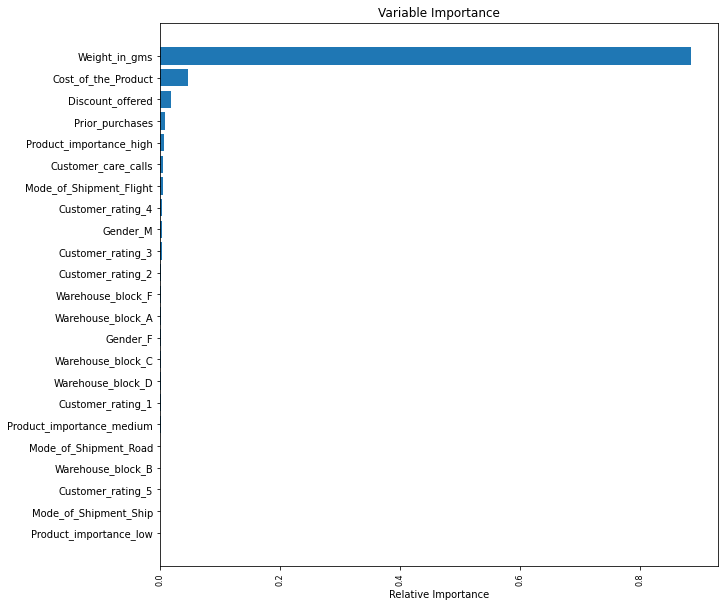

In [ ]:
features = data.columns
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xticks(fontsize=8, rotation=90)
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


# Appendix-Brouillons (visualisations et processing)


Appendix) Brouillons visualisations

In [ ]:
#Visualisation 1 : Usage des différents modes d'expédition
plt.figure(figsize=[7,4])
sns.countplot(data=df, x="Mode_of_Shipment", order = df['Mode_of_Shipment'].value_counts().index)
plt.title("Usage des différents modes d'expédition");

In [ ]:
#Visualisation 2 : Usage en % des modes d'expédition
plt.figure(figsize=[7,4])
df['Mode_of_Shipment'].value_counts().plot(kind='pie', fontsize=12,autopct='%1.1f%%', startangle=0, shadow = True, explode= (0.1, 0,0))
plt.title("% d'usage des modes d'expédition");

In [ ]:
# Visualisation 3 : Réponse à la question : Les commandes sont-elles livrées à temps ?
ax = sns.barplot(x="Reached.on.Time_Y.N", y='Reached.on.Time_Y.N', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="% des commandes")
plt.title("Timing de livraison")
plt.xticks([0,1],['En retard','A temps']);

In [ ]:
#Autres visualisations possibles
#Visualisation 4
plt.figure(figsize = (12,12))
plt.subplot(321)
df['Reached.on.Time_Y.N'].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%')
plt.title("Répartition des commandes arrivées à temps")
plt.subplot(322)
sns.countplot(x = "Reached.on.Time_Y.N", hue = "Mode_of_Shipment", data = df)
plt.title("Répartition des commandes arrivées à temps selon le mode de transport")
plt.subplot(322)
sns.catplot(x = "Reached.on.Time_Y.N", y = "Customer_rating",kind = "box", data = df)
plt.title("Répartition des commandes arrivées à temps selon la notation client");

In [ ]:
#Traitement des valeurs aberrantes ?

#Ideas
#Relation Between Weight of The Product in Grams - Discount Offered
#Which Mode of Shipment is Faster Than Others?
#What is The Number of Times The Products Stored In Each Warehouse Arrive on Time?
#Which Gender is More Satisfied With The Orders?

#Visualisations To Do
#1) "Customer Care Calls" VS  "Cost of The Product" corrélation faible (0.32) -> Boites à Moustache (x nombre d'appels / y coût) : Thierry (Done)
#2) "Reached on Time" VS "Discount Offered" corrélation modérée (0.40) -> Histogramme (TBC) : Vivien (Done)
#3) Visualisations pour repérer valeurs aberrantes : Corine (Done)
#4) "Weight_in_gms" VS "Discount_offered" corrélation négatif (-0.38):  Xiyuan


In [ ]:
#Visualisation 5 : Comparaison entre le Discount et le timing de livraison 
#Rappel : Il y a une corrélation modérée entre "Reached on Time" et "Discount Offered" (0.40)
# Les produits dont la remise est inférieure à 10 ont une plus grande probabilité d'arriver
df_ontime = df[df["Reached.on.Time_Y.N"] == 1]
df_late = df[df["Reached.on.Time_Y.N"] == 0]

plt.figure(figsize=[10,5])
plt.hist(x = [df_ontime["Discount_offered"], df_late["Discount_offered"]], bins= [0,10,20,40], label = ["A temps","En retard"])
plt.xlabel("Discount (en %)")
plt.ylabel("Nombre de commandes")
plt.title("Comparaison entre la présence d'un discount et le timing de livraison")
plt.legend();

In [ ]:
#Visualisation 6 : Comparaison entre le Discount et le timing de livraison (en %)

df_discount = df[df["Discount_offered"] > 1]
df_nodiscount = df[df["Discount_offered"] == 1]

plt.figure(figsize=[5,10])

plt.subplot(2,1,1)
df_discount['Reached.on.Time_Y.N'].value_counts().plot(kind='pie', fontsize=12,autopct='%1.1f%%', startangle=0, labels = ["A temps", "En retard"])
plt.title("Timing de livraison des commandes AVEC discount")
plt.legend();

plt.subplot(2,1,2)
df_nodiscount['Reached.on.Time_Y.N'].value_counts().plot(kind='pie', fontsize=12, autopct='%1.1f%%', startangle=0, labels = ["A temps", "En retard"])
plt.title("Timing de livraison des commandes SANS discount")
plt.legend();



In [ ]:
#  Visualisation 7 : Relation "Weight_in_gms" VS "Discount_offered" corrélation négatif (-0.38)
fig, ax =plt.subplots(figsize=(10, 5))
sns.scatterplot(x="Discount_offered", y="Weight_in_gms", hue='Reached.on.Time_Y.N',
                data=df, ax=ax);

# remiese jusqu'à 10% sur les produits de plus de 4 kg
# plus le produit est lourd, plus la remise est faible, cela explique la corrélation néfatif
# 6 produis exceptionnelles

# resumer: les produits a été livré à temps lorsque la remise est inférieure à 10% et que le poids est de 1-2kg ou 4-6kg,
# les produits pesant entre 2 et 4kg et les produits dont la remise est supérieure à 10% n'arrivent pas à temps.

In [ ]:
# Visualisation 9: la plupart des colis sont stockés dans l'entrepôt F
# la livraison de cet entrepôt a un impact important sur le variable cible
sns.catplot(x="Warehouse_block", kind="count", hue='Mode_of_Shipment',data=df);


In [ ]:
#Dès lors nous pouvons analyser les corrélationsentre les variables
#Visualisation 10 : Corrélation entre les variables
cor=df.corr()
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor, annot=True, ax=ax, cmap = "coolwarm");
# Comme on peut le voir sur le graphique ci-dessous, les trois groupes suivants sont en corrélation :
#"Reached on Time" VS "Discount Offered" corrélation modéré (0.40)
#"Customer Care Calls" VS  "Cost of The Product" corrélation faible (0.32)
#"Weight of The Product in Grams" VS "Discount Offered" corrélation faible négative(-0.38)

In [ ]:
#Visualisations To Do
#1) "Customer Care Calls" VS  "Cost of The Product" corrélation faible (0.32) -> Boites à Moustache (x nombre d'appels / y coût) : Thierry

#Visualisation 11 : j'émets l'hypothèse que plus le produit est cher plus le client va demander des informations sur le suivi des expéditions
sns.catplot(x = "Customer_care_calls", y = "Cost_of_the_Product",kind = "box", data = df)
plt.title("Dispersion du coût des produits par nombre de customer calls");
#hypothèse confirmée

In [ ]:
# Visualisation 12 : j'émets l'hypothèse que le warehouse de stockage a un impact sur la livraison dans les temps des produits
sns.catplot(x="Warehouse_block", kind="count", hue='Reached.on.Time_Y.N',data=df);
# Hypothèse non confirmée : la proportion semble la même quel que soit l'entrepôt

In [ ]:
#Visualisation 13 :  j'émets l'hypothèse que la plupart des produits importants sont transportés par avion
sns.countplot(df['Mode_of_Shipment'], hue=df['Product_importance']);

# Faux, la pluspart des produits sont expédiés par voie maritime, y compris la plupart des produits importants

In [ ]:
# visualisation 14: j'émets l'hypothese que le gender n'a pas d'importance pour le note de client, nombre d'appel et nombres d'achats
j = 1
var = ['Customer_rating','Customer_care_calls','Prior_purchases']
plt.figure(figsize = (15,5))
for i in var:
    plt.subplot(1,3,j)
    sns.countplot(x = i , data = df, hue= 'Gender')
    j +=1

# Nous observons que les chiffres pour les deux sexes sont à peu près égaux.
# Vérifié l'hypothese 

In [ ]:
#visualisation 15: 
ct_counts=df.groupby(['Product_importance','Reached.on.Time_Y.N']).size()
ct_counts=ct_counts.reset_index(name='count')
ct_counts=ct_counts.pivot(index='Product_importance',columns='Reached.on.Time_Y.N',values='count')
sns.heatmap(ct_counts,annot=True,fmt='d');
plt.title('On time shiping rate per each product quality',fontsize=16);

In [ ]:
print('High quality product rate:',round(394/(394+279),2)*100,'%')
print('Low quality product rate:',round(1688/(1688+1493),2)*100,'%')
print('med quality product rate:',round(1629/(1639+1453),2)*100,'%')
# Les produits de haute qualité ont le meilleur taux d'expédition dans les délais.

In [ ]:
#repérer les valeurs aberrantes ==> la boîte à moustache
#sur les boites à moustaches sont représentés la médiane, les quartiles 25% et 75% ainsi les valeurs 
#les plus extrêmes dans la limite de 1.5 fois la hauteur de la boîte.
#Comment repérer les valeurs aberrantes ?
#Les valeurs qui sont juste au-dessus des boîtes à moustaches ne sont pas considérées 
#comme des valeurs aberrantes mais plutôt comme des valeurs extrêmes.
#Ces valeurs ne semblent pas relever une anomalie dans notre jeu de données à 
#linverse de celles qui se trouvent particulièrement eloignées des autres, celles qui sont isolées.
#Ces dernieres seront considérées comme aberrantes. 
#liste des variables à représenter
groupe_variables = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms']
for i in groupe_variables:
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    sns.boxplot(y=df[i], x=df['Reached.on.Time_Y.N'], ax=axs, color='#16E4CA')
    plt.title(i)

In [ ]:
#Suite à la visualisation des différentes variables retenues explicatives en fonction de la variable à expliquer
#nous pouvons supprimer les valeurs supérieures à 1.5 fois la hauteur de la boîte à moustache
df = df[df['Weight_in_gms'] > 2500]
df = df[df['Prior_purchases']< 6.5]
df.head()

In [ ]:
#Vérification des doublons
df.duplicated().sum()
#Conclusion : nous n'avons pas de doublons dans notre dataset

In [ ]:
#Suite aux diférentes visualisations efectuées il apparaît que les variables agissant sur l'arrivée en temps et en heure sont principalement : le prix du produit, le nombre d'appel des clients (par ricochet du prix du produit), le discount offert et le poids de l'expédition.
#Les autres variables n'agissent à priori pas sur le résultat.

Appendix) Brouillons processing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66) 

In [ ]:
#Classificaiton par régression logistique
from sklearn.metrics import confusion_matrix 
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']) 
print(cm)
print('score de la régression logistique est: ',clf.score(X_test, y_test) )

In [ ]:
# Random Forest
from sklearn import ensemble
from sklearn.model_selection import train_test_split
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print('score de Random Forest est: ',clf.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import train_test_split
data = df_dummy_encoded.iloc[:,7:-1]
target = df_dummy_encoded['On_Time?']

data.head(5)


KNN

In [ ]:
# création d'une instance clfknn avec un paramétrage au "hasard" et apprentissage
from sklearn import neighbors
clfknn = neighbors.KNeighborsClassifier(n_neighbors=10)
clfknn.fit(X_train,y_train)


In [ ]:
# fixation des paramètres 
parametresknn =[{"n_neighbors":list(range(2,50))}]

# recherche des hyperparamètres retenus 
from sklearn import model_selection
grid_clfknn = model_selection.GridSearchCV(estimator=clfknn, param_grid=parametresknn)
grid_clfknn.fit(X_train, y_train)
print(grid_clfknn.best_params_)


In [ ]:
# application du modèle à l'ensemble de test et affichage de la matrice de confusion
y_pred = grid_clfknn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])




In [ ]:
# affichage du score du modèle
print(grid_clfknn.best_score_) 
#Le best score trouvé est meileur que le score de départ en comparaison des modèles.

In [ ]:
 # KNN avec hyperparamètres

In [ ]:
from sklearn import neighbors
from sklearn import model_selection
knn = neighbors.KNeighborsClassifier()
parametres = {'n_neighbors': range(2,50)}
grid_knn = model_selection.GridSearchCV(estimator=knn, param_grid=parametres)

grid_knn.fit(X_train, y_train)


Les ratio sont : [0.15479524 0.14792739 0.09323882 0.09266437 0.0917891  0.09024626
 0.08884033 0.07961961 0.06296392 0.05730058 0.04061439]


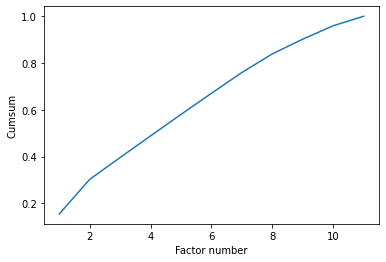

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_ACP=df.replace(['A','B','C','D','F'],[0,1,2,3,4])
df_ACP=df_ACP.replace(['Flight','Ship','Road'],[0,1,2])
df_ACP=df_ACP.replace(['low', 'medium', 'high'],[0,1,2])
df_ACP=df_ACP.replace(['F', 'M'],[0,1])

scaler = StandardScaler()
Z = scaler.fit_transform(df_ACP)

pca=PCA()
Coord = pca.fit_transform(Z)
print('Les ratio sont :',pca.explained_variance_ratio_)

plt.plot(np.arange(1, 12), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Factor number')
plt.ylabel('Cumsum');

Les valeurs propres sont : [1.70290242 1.62734924 1.02572024 1.01940074 1.00977192 0.99279915
 0.97733249 0.8758953  0.69266607 0.63036369 0.44679892]


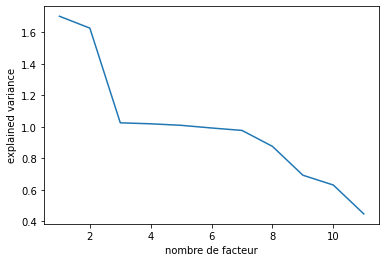

In [ ]:
print('Les valeurs propres sont :', pca.explained_variance_) # pour chaque composantes de PCA

plt.plot(np.arange(1,12), pca.explained_variance_)
plt.xlabel('nombre de facteur')
plt.ylabel('explained variance');

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=66)

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print('score:',dt_clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred_dt, rownames = ['Classes rélles'], colnames = ['Classes prédites'])


score: 0.6554545454545454


Classes prédites,0,1
Classes rélles,,
0,509,361
1,397,933


In [ ]:
data_test = X_test.join(y_test)
data_test = data_test.reset_index()
list = pd.DataFrame(y_pred_dt)
data_test_pred = data_test.join(list)
data_test_pred.rename({0: 'predict'}, axis=1, inplace=True)

In [ ]:
df_bis = df1.drop("ID", axis=1)
df_bis = df_bis.reset_index()

data_test_pred_bis = data_test_pred[['index', 'On_Time?', 'predict']]

data_test_pred_bis = data_test_pred_bis.merge(df_bis, on = 'index', how = 'left')

good_predict = data_test_pred_bis[data_test_pred_bis["On_Time?"] == data_test_pred_bis["predict"]]
bad_predict = data_test_pred_bis[data_test_pred_bis["On_Time?"] != data_test_pred_bis["predict"]]


In [ ]:
## Warehouse_block
bad_w = bad_predict['Warehouse_block'].value_counts(normalize = True)
good_w = good_predict['Warehouse_block'].value_counts(normalize = True)
print(bad_w)
print(good_w)

F    0.313984
B    0.175462
A    0.172823
D    0.172823
C    0.164908
Name: Warehouse_block, dtype: float64
F    0.343273
C    0.171290
D    0.169903
B    0.160888
A    0.154646
Name: Warehouse_block, dtype: float64


In [ ]:
## Mode_of_Shipment
bad_s = bad_predict['Mode_of_Shipment'].value_counts(normalize = True)
good_s = good_predict['Mode_of_Shipment'].value_counts(normalize = True)
print(bad_s)
print(good_s)

Ship      0.659631
Road      0.174142
Flight    0.166227
Name: Mode_of_Shipment, dtype: float64
Ship      0.676838
Flight    0.168516
Road      0.154646
Name: Mode_of_Shipment, dtype: float64


In [ ]:
## Customer_care_calls
bad_cc = bad_predict['Customer_care_calls'].value_counts(normalize = True)
good_cc = good_predict['Customer_care_calls'].value_counts(normalize = True)
print(bad_cc)
print(good_cc)

4    0.329815
3    0.265172
5    0.208443
6    0.117414
2    0.048813
7    0.030343
Name: Customer_care_calls, dtype: float64
4    0.333564
3    0.301664
5    0.199723
6    0.081831
2    0.068655
7    0.014563
Name: Customer_care_calls, dtype: float64


In [ ]:
## Prior_purchases
bad_pp = bad_predict['Prior_purchases'].value_counts(normalize = True)
good_pp = good_predict['Prior_purchases'].value_counts(normalize = True)
print(bad_pp)
print(good_pp)

3     0.317942
4     0.241425
2     0.220317
5     0.131926
6     0.054090
10    0.014512
8     0.011873
7     0.007916
Name: Prior_purchases, dtype: float64
3     0.372399
2     0.251040
4     0.177531
5     0.108877
6     0.047850
10    0.015257
7     0.014563
8     0.012483
Name: Prior_purchases, dtype: float64


In [ ]:
## Product_importance
bad_pi = bad_predict['Product_importance'].value_counts(normalize = True)
good_pi = good_predict['Product_importance'].value_counts(normalize = True)
print(bad_pi)
print(good_pi)

low       0.480211
medium    0.444591
high      0.075198
Name: Product_importance, dtype: float64
low       0.463245
medium    0.434813
high      0.101942
Name: Product_importance, dtype: float64


In [ ]:
## customer_rating
bad_pi = bad_predict['Customer_rating'].value_counts(normalize = True)
good_pi = good_predict['Customer_rating'].value_counts(normalize = True)
print(bad_pi)
print(good_pi)

3    0.211082
1    0.207124
4    0.197889
2    0.193931
5    0.189974
Name: Customer_rating, dtype: float64
4    0.211512
3    0.199029
2    0.199029
1    0.199029
5    0.191401
Name: Customer_rating, dtype: float64


In [ ]:
## exploration de données
# datavis 2
num_data = df.select_dtypes(include=['int64','float64'])
num_data_vis2= pd.DataFrame( num_data, columns = ['Discount_offered'])
num_data_vis2.head()
num_data_vis3 = pd.DataFrame( num_data, columns = ['Discount_offered','Weight_in_gms'])
num_data_vis3

,Discount_offered,Weight_in_gms
0,44,1233
1,59,3088
2,48,3374
3,10,1177
4,46,2484
...,...,...
10994,1,1538
10995,6,1247
10996,4,1155
10997,2,1210


In [ ]:
stats = pd.DataFrame(num_data_vis2.mean(),columns=['moyenne'])

stats['mediane']=num_data_vis2.median()
stats['mean_med_diff'] = abs(stats['moyenne']-stats['mediane'])
stats[['q1','q2','q3']] = num_data_vis2.quantile(q=[0.25,0.5,0.75]).transpose()
stats['min'] = num_data_vis2.min()
stats['max'] = num_data_vis2.max()
stats['min_max_diff'] = stats['max'] - stats['min']
stats.round(2)


,moyenne,mediane,mean_med_diff,q1,q2,q3,min,max,min_max_diff
Discount_offered,13.37,7.0,6.37,4.0,7.0,10.0,1,65,64


In [ ]:
stats = pd.DataFrame(num_data_vis3.mean(),columns=['moyenne'])

stats['mediane']=num_data_vis3.median()
stats['mean_med_diff'] = abs(stats['moyenne']-stats['mediane'])
stats[['q1','q2','q3']] = num_data_vis3.quantile(q=[0.25,0.5,0.75]).transpose()
stats['min'] = num_data_vis3.min()
stats['max'] = num_data_vis3.max()
stats['min_max_diff'] = stats['max'] - stats['min']
stats.round(2)

,moyenne,mediane,mean_med_diff,q1,q2,q3,min,max,min_max_diff
Discount_offered,13.37,7.0,6.37,4.0,7.0,10.0,1,65,64
Weight_in_gms,3634.02,4149.0,514.98,1839.5,4149.0,5050.0,1001,7846,6845
